In [23]:
import pandas as pd
import numpy as np
import random 
import re 
import os 
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce 

from sklearn.metrics import (    accuracy_score,    confusion_matrix,f1_score,precision_score, recall_score,roc_auc_score)
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,cross_val_score, StratifiedShuffleSplit

from sklearn.tree import DecisionTreeClassifier

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder

In [24]:
pd.set_option('display.max_rows', 500)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [25]:
nation_corp = {
    'Austria': ['LGEAG'],    'Czech Republic': ['LGECZ'],    'France': ['LGEFS'],    'Germany': ['LGEDG'],    'Greece': ['LGEHS'],    'Hungary': ['LGEMK'],    'Italy': ['LGEIS'],    'Netherlands': ['LGESC', 'LGEEH', 'LGEBN'],    'Poland': ['LGEWR', 'LGEPL', 'LGEMA'],    'Portugal': ['LGEPT','LGEBT'],
    'EUs': ['LGEEB'],    'Romania': ['LGERO'],    'Spain': ['LGEES'],    'Sweden': ['LGENO', 'LGESW'],    'United Kingdom': ['LGEUK'],      'Kazakhstan': ['LGEAK'],    'Russia': ['LGERM', 'LGERI', 'LGERA'],
    'Ukraine': ['LGEUR'],    'Latvia': ['LGELV','LGELA'],    'Algeria': ['LGEAS'],
    'Egypt': ['LGEEG'],    'Jordan': ['LGELF'],    'Kenya': ['LGESK','LGEEF'],    'Morocco': ['LGEMC'],
    'Saudi Arabia': ['LGESJ'],    'Iran':['LGEIR'],     'Israel':['LGEYK'],     'The Republic of South Africa': ['LGESA'],
    'Tunisia': ['LGETU'],    'U.A.E': ['LGEOT', 'LGEDF', 'LGEGF', 'LGEME', 'LGEAF'],    'Nigeria': ['LGEAO', 'LGENI'],
    'Turkey': ['LGETK', 'LGEAT'],    'Australia': ['LGEAP'],
    'China': ['LGEQA', 'LGETL', 'LGECH', 'LGEYT', 'LGETR', 'LGETA', 'LGESY', 'LGESH', 'LGEQH', 'LGEQD', 'LGEPN', 'LGEND', 'LGEKS', 'LGEHZ', 'LGEHN', 'LGEHK'],
    'India': ['LGEIL'],    'Indonesia': ['LGEIN'],    'Japan': ['LGEJP'],    'Malaysia': ['LGEML'],    'Philippines': ['LGEPH'],
    'Singapore': ['LGESL'],    'Taiwan': ['LGETT'],    'Korea' :['LGEKR'],    'Thailand': ['LGETH'],    'Vietnam': ['LGEVN','LGEVH'],
     'Canada': ['LGECI'],    'Mexico': ['LGERS', 'LGEMX', 'LGEMS', 'LGEMM'],    'United States': ['LGEMR', 'LGEUS', 'LGEMU', 'LGEAI'],
    'Argentina': ['LGEAG','LGEAR'],    'Brazil': ['LGEBR','LGESP'],    'Chile': ['LGECL'],    'Colombia': ['LGEVZ', 'LGECB'],
    'Panama': ['Guatemala', 'LGEPS'],    'Peru': ['LGEPR']}
continent_nation={
    'Europe':['EUs','Austria', 'Czech Republic' ,'France' ,'Germany', 'Greece' ,'Hungary', 'Italy', 'Netherlands' ,'Poland' ,'Portugal' ,'Romania', 'Spain' ,'Sweden','United Kingdom'], 
    'Russia and CIS':['Kazakhstan','Russia', 'Ukraine', 'Latvia'],     'Africa and MiddleEast': ['Israel','Iran','Algeria', 'Egypt', 'Jordan', 'Kenya', 'Morocco','Saudi Arabia','The Republic of South Africa','Tunisia', 'U.A.E', 'Nigeria', 'Turkey'], 
    'Asia':['Korea','Australia','China','India','Indonesia','Japan','Malaysia','Philippines','Singapore','Taiwan','Thailand','Vietnam'], 
    'NorthAmerica' : ['Canada','Mexico','United States'],    'SouthAmerica' :['Argentina','Brazil','Chile','Colombia','Panama','Peru']
    
}
hemisphere = {
    'Northern': ['EUs', 'Austria', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden', 'United Kingdom', 'Kazakhstan', 'Russia', 'Ukraine', 'Latvia', 'Israel', 'Iran', 'Jordan', 'Morocco', 'Saudi Arabia', 'Tunisia', 'Turkey', 'Korea', 'China', 'Japan', 'Taiwan', 'Canada', 'United States', 'Mexico', 'Panama'],
    'Southern': ['Algeria', 'Egypt', 'Kenya', 'The Republic of South Africa', 'U.A.E', 'Nigeria', 'Australia', 'India', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Peru']
}
mapping_dict = {

    "others": "Other",
    "Others": "Other",
    "other_": "Other",
    "other": "Other",
    "Etc.": "ETC.",
}

In [26]:
# 데이터 생성 및 전처리 함수 
def get_datas():
    train = pd.read_csv("/home/workspace/LGamiers/train.csv")
    test = pd.read_csv("/home/workspace/LGamiers/submission.csv").drop(['id','is_converted'], axis =1) # 테스트 데이터(제출파일의 데이터)
    train['is_converted']=np.where(train['is_converted']==True,1,0)
    return train, test 


def delete_cols(data, cols):
    data = data.drop(columns=cols)
    return data

def log_transform(data,cols):
    for col in cols :
        data[col+'log']=np.log1p(data[col]) 
    return data 


def eda_expected_timeline(df):
    
    def timeline_label(time):
    
        time = str(time).lower().replace(' ','').replace('_','').replace('/','').replace(',','').replace('~','').replace('&','').replace('-','').replace('.','')
        
        if time == 'lessthan3months':
            result = 'less than 3 months'
        elif time == '3months6months':
            result = '3 months ~ 6 months'
        elif time == '6months9months':
            result = '6 months ~ 9 months'
        elif time == '9months1year':
            result = '9 months ~ 1 year'
        elif time == 'morethanayear':
            result = 'more than a year'
        else:
            result = time
            
        return result
    
    df['expected_timeline'] = df['expected_timeline'].apply(timeline_label)
    
    return df


# inquiry type 전처리하기 
def eda_inquiry_type(df):
    df['inquiry_type']= df['inquiry_type'].map(mapping_dict).fillna(train['inquiry_type'])
    df.loc[df['inquiry_type'].str.contains('Solicito apoyo para realizar', na=False), 'inquiry_type'] = 'Quotation or Purchase Consultation'
    df['inquiry_type'] = df['inquiry_type'].str.lower()
    replacement = {'/': ' ', '-':' ', '_':' '}
    df['inquiry_type'].replace(replacement, regex=True, inplace=True)
    return df

def eda_inquiry_type_customer_position(df):
# inquiry_type feature 전처리 
    # customer_position feature 전처리 
    df['inquiry_type'] = df['inquiry_type'].str.lower()
    df['customer_position'] = df['customer_position'].str.lower()
    
    # 특수문자를 대체 문자열 지정
    replacement = {'/': ' ', '-':' ', '_':' '}
    # replace() 함수를 사용하여 특수 문자 대체
    df['inquiry_type'].replace(replacement, regex=True, inplace=True)
    df['customer_position'].replace(replacement, regex=True, inplace=True)
    
    # value count의 값이 1개인 feature name extraction (해당 방식 토의) 
    inquiry_series = df['inquiry_type'].value_counts()
    customer_position_series = df['customer_position'].value_counts()
    inquiry_replace_feature = []
    customer_replace_feature = []

    for idx, feature in enumerate(inquiry_series.index):
        if inquiry_series[idx] == 1:
            inquiry_replace_feature.append(feature)

    for idx, feature in enumerate(customer_position_series.index):
        if customer_position_series[idx] == 1:
            customer_replace_feature.append(feature)

    # 총 39개의 데이터 Concat
    df['inquiry_type'] = df['inquiry_type'].apply(lambda x: 'aimers_0203' if x in inquiry_replace_feature else x)
    # 총 53개의 데이터 Concat 
    df['customer_position'] = df['customer_position'].apply(lambda x: 'aimers_0203' if x in customer_replace_feature else x)

    return df

#customer type 처리 
def customer_type(data):
    data['customer_type']=data['customer_type'].fillna('none') 
    return data

# total_area 변수로 통일
def eda_business_area(df):
    for col in ['business_area','business_subarea']:
        df[col] = df[col].str.lower()
        df[col] = df[col].str.replace(" ", "") 
        df[col] = df[col].str.replace(r'[^\w\s]', "") 
        df[col] = df[col].fillna('nan') 
    df['total_area'] = df['business_area'].astype(str) + df['business_subarea'].astype(str)
    return df 

# 새로운 국가명, 대륙 열을 만들기 
def get_nation_continent(df):
    nation_corp_reverse ={v:k for k , values in nation_corp.items() for v in values }
    df['nation']=df['response_corporate'].map(nation_corp_reverse)
    continent_nation_reverse ={v:k for k , values in continent_nation.items() for v in values }
    df['continent']=df['nation'].map(continent_nation_reverse)
#     df = df.drop('customer_country',axis=1) 
    return df 

#라벨 인코딩 
def label_encoding(series: pd.Series) -> pd.Series:
    my_dict = {}
    series = series.astype(str)
    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)
    return series

# com_reg_ver_win_rate 최빈값으로 채우기 
def com_reg_fill(train,test):
    train['com_reg_ver_win_rate'] = train['com_reg_ver_win_rate'].fillna(train['com_reg_ver_win_rate'].mode()[0])
    test['com_reg_ver_win_rate'] = test['com_reg_ver_win_rate'].fillna(train['com_reg_ver_win_rate'].mode()[0])
    return train,test

#****************************Feature Engineering*************************************#

def fe_1(train,test):
    # unit continent으로 엮어서 영업 전환율 살펴보기 -> 'unit_conti_mean'열 새로 생성
    # 대륙별로 어느 사업부에 영업 성공율이 높은 지 
    se=train.groupby(['business_unit','continent'])['is_converted'].agg(['mean'])
    se = se.rename(columns={'mean':'unit_conti_mean'})
    train =train.merge(se, on=['business_unit','continent'], how ='left')
    test =test.merge(se, on=['business_unit','continent'], how ='left')
    return train,test 

def fe_2(train,test):
    # 영업 당담자가 어느 정도로 다양한 회사(customer_idx)을 담당하고 있는 지 
    
#     count = train.groupby('lead_owner').size().reset_index(name='leadowner_cnt')     
#     train = train.merge(count, on='lead_owner', how='left')
#     train['leadowner_cnt']= np.log1p(train['leadowner_cnt'])
#     test = test.merge(count, on='lead_owner', how= 'left')
#     test['leadowner_cnt']=np.log1p(test['leadowner_cnt'])
    unique_count = train.groupby('lead_owner')['customer_idx'].nunique().reset_index(name='unique_cusidx_cnt')
    train = train.merge(unique_count, on='lead_owner', how='left')
    test = test.merge(unique_count,on ='lead_owner',how ='left')
    train['unique_cusidx_cnt']= np.log1p(train['unique_cusidx_cnt'])
    test['unique_cusidx_cnt']= np.log1p(test['unique_cusidx_cnt'])
    
    return train, test 

def fe_3(train,test):
    # 영업담당자와 사업부로 영업전환 성공률 살펴보기 -> 어느 사업부를 어느 담당자가 담당해야 성공율이 높나 확인 

    se = train.groupby(['lead_owner','business_unit'])['is_converted'].agg(['mean']).rename(columns={'mean': 'owner_unit_mean'})
    train = train.merge(se, on=['lead_owner','business_unit'], how='left')
    test = test.merge(se, on=['lead_owner','business_unit'],how='left')
    return train, test

def fe_4(train,test):
    # customer_idx가 대기업, 중소기업으로 분류되는 경우 1을 부여 
    se = train[train.groupby('customer_idx')['enterprise'].transform('nunique') > 1]
    multi_company=list(se['customer_idx'].unique())
    train['multi_company']=np.where(train['customer_idx'].isin(multi_company) ,1,0)
    test['multi_company']=np.where(test['customer_idx'].isin(multi_company) ,1,0)
    return train, test

def fe_5(train,test):
    # LG지점 , 사업부 , bantsubmit으로 영업 성공율 살펴보기 -> 너무 과적합됨으로 제외 
    se = train.groupby(['response_corporate','business_unit','bant_submit'])['is_converted'].agg(['mean']).rename(columns={'mean':'idx_unit_mean'})
    train=train.merge(se,on=['response_corporate','business_unit','bant_submit'], how ='left')
    test=test.merge(se,on=['response_corporate','business_unit','bant_submit'], how ='left')
    return train, test
def fe_6(train,test):
    # 영업사원, 사업부, bandsubmit 으로 영업 성공율 살펴보기 -> 과적합으로 제외 
    se = train.groupby(['lead_owner','business_unit','bant_submit'])['is_converted'].agg(['mean']).rename(columns={'mean':'idx_unit_mean'})
    train=train.merge(se,on=['lead_owner','business_unit','bant_submit'], how ='left')
    test =test.merge(se,on =['lead_owner','business_unit','bant_submit'], how ='left')
    return train, test


def fe_7(train,test):
    # bant submit 제곱하기 -> isconverted와 corr는 더 높지만 성능향상은 없음 
    train['bant_submit2']=train['bant_submit']*train['bant_submit']
    test['bant_submit2']=test['bant_submit']*test['bant_submit']
    return train, test


def fe_8(df):
    # 국가별로 북반구와 남반구 특성을 생성하기 
    hemisphere_reverse ={v:k for k , values in hemisphere.items() for v in values }
    df['hemisphere'] =df['nation'].map(hemisphere_reverse)
    return df 

def fe_9(train,test):
    # 대륙별,사업 분야별, 사업부로 영업 성공률 살피기 
    se=train.groupby(['business_area','business_unit','continent'])['is_converted'].agg(['mean'])
    se = se.rename(columns={'mean':'area_unit_conti_mean'})
    train =train.merge(se, on=['business_area','business_unit','continent'], how ='left')
    test =test.merge(se, on=['business_area','business_unit','continent'], how ='left')
    return train, test

def fe_10(train,test):
    #국가별, 고객의 직업에 따라서 영업 성공율 살펴보기 
    se =train.groupby(['nation','customer_job'])['is_converted'].agg(['mean']).rename(columns={'mean':'nat_job_mean'})
    
    train =train.merge(se, on =['nation','customer_job'], how = 'left')
    train['nat_job_mean']=train['nat_job_mean'].fillna(train['nat_job_mean'].mean())
    
    test =test.merge(se, on =['nation','customer_job'], how = 'left')
    test['nat_job_mean']=test['nat_job_mean'].fillna(train['nat_job_mean'].mean())
    return train,test 


def fe_12(train,test):
    train['com_product'] = train['product_category'].apply(lambda x: 1 if 'signage' in str(x) else 0)
    
    se= train.groupby(['customer_idx'])['com_product'].agg(['mean']).rename(columns={'mean':'com_prod_mean'})
    train = train.merge(se, on =['customer_idx'], how ='left')
    test = test.merge(se, on =['customer_idx'], how ='left')
    train= train.drop('com_product', axis= 1 )
    return train,test
    
def create_grouped_features(train, test, group, numeric_var):
    # 범주형 특성들에 대해서 다른 수치형 데이터의 중앙값, 최대, 합을 새로운 열로 추가하기 
    train = train.copy()
    test = test.copy()

    aggs = ['median', 'max', 'sum']

    for agg in aggs:
        # groupby 후 aggregation
        a1 = train.groupby([group])[numeric_var].agg(agg).to_dict()
        # 새로운 feature 생성
        train[numeric_var+'_'+group+'_'+agg] = train[group].map(a1)
        test[numeric_var+'_'+group+'_'+agg] = test[group].map(a1)
    return train, test

def do_scale(train,test, scale_cols) :
    for c in scale_cols:
        min_value = train[c].min()
        max_value = train[c].max()
        train[c+"_scaled"] = (train[c] - min_value) / (max_value - min_value)
        test[c+"_scaled"] = (test[c] - min_value) / (max_value - min_value)
    return train,test

# def count_encoding(train, test, cols):
#     idx = len(train)
#     df = pd.concat([train, test], axis=0)
#     for col in cols:
#         df[col+'_ce'] = df[col].map(df[col].value_counts(dropna =False))

#     return df[:idx], df[idx:] 

def make_in_purchase(df):
    df.reset_index(drop=True, inplace=True)
    token_list = df['inquiry_type'].str.split()
    df['in_purchase'] = 0
    for i in range(len(df)):
        # nan 처리
        if type(token_list[i]) == float:
            continue
        if 'purchase' in token_list[i]:
            df['in_purchase'][i] = 1 
    return df

def change_purchase(train, test):
    df = pd.concat([train, test])
    idx = len(train)
    df.reset_index(drop=True, inplace=True)
    token_list = df['inquiry_type'].str.split()
    for i in range(len(df)):
        # nan 처리
        if type(token_list[i]) == float:
            continue
        if 'purchase' in token_list[i]:
            df['inquiry_type'][i] = 'purchase' 
    return df[:idx], df[idx:] 

def same_word_detect(train, test, categorical_list):
    df = pd.concat([train, test], axis=0)
    idx = len(train)
    for feature in categorical_list:
        df[feature] = df[feature].str.lower()
        # replace() 함수를 사용하여 특수 문자 대체
        df[feature] = df[feature].str.replace(pat=r'[^\w\s]', repl=r' ', regex=True)
        df[feature] = df[feature].str.replace(pat=r'_', repl=r' ', regex=True)
        
    return df[:idx], df[idx:]

In [27]:
def label_encoding(series):
    # """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}
    # 모든 요소를 문자열로 변환
    mode = np.flip(series.value_counts().index.values)
    # unique value 찾고 아스키코드 기준으로 sort
    # my_dict을 통해 unique value에 대응하는 label 생성 
    for idx, value in enumerate(mode):
        my_dict[value] = idx
    # my_dict의 index와 매치되는 series값을 my_dict의 value로 변환한다.
    series = series.map(my_dict)

    return series



In [28]:
groups = ['business_unit','customer_idx']
numeric_vars = ['historical_existing_cnt', 'lead_desc_length']
scale_cols = ['com_reg_ver_win_rate','historical_existing_cnt', 'lead_desc_length','ver_win_rate_x']

In [29]:
# data 갖고오기 
train,test= get_datas() 

# 스케일링 하기 
train,test =do_scale(train,test,scale_cols)

# 범주형 데이터에 대해 수치형 데이터 통계값 추가
for group in groups:
    for numeric_var in numeric_vars:
        train, test = create_grouped_features(train, test, group, numeric_var)
        
# 전처리, 로그변환 수행하기 
columns_to_log=['com_reg_ver_win_rate','lead_desc_length']
train,test= log_transform(train,columns_to_log ),log_transform(test,columns_to_log)
train,test =eda_business_area(train),eda_business_area(test)
train,test= get_nation_continent(train),get_nation_continent(test)
train,test=eda_expected_timeline(train) ,eda_expected_timeline(test)
train,test=customer_type(train) ,customer_type(test)
train,test=eda_inquiry_type(train) ,eda_inquiry_type(test)
train,test= same_word_detect(train, test, train.dtypes[train.dtypes=='object'].index.values)
# Feature Engineering 
train,test = fe_1(train,test)
train,test = fe_2(train,test)
train,test = fe_3(train,test)
train,test = fe_9(train,test)
train,test = fe_10(train,test)
train = make_in_purchase(train)
test = make_in_purchase(test)
# train,test = count_encoding(train,test,['customer_idx'])


# train,test = fe_12(train,test)

for col in ['customer_idx','customer_type']:
    train[col+'count'] =train[col].map(train[col].value_counts())
    test[col+'count'] =test[col].map(train[col].value_counts())

In [30]:
train[train['product_category'] == 'tv']

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,nation,continent,unit_conti_mean,unique_cusidx_cnt,owner_unit_mean,area_unit_conti_mean,nat_job_mean,in_purchase,customer_idxcount,customer_typecount
2537,0.25,egypt,id,NaN,25096,none,enterprise,NaN,NaN,NaN,...,egypt,africa and middleeast,0.096409,4.836282,0.057971,0.156051,0.082138,0,2421,43961
26897,0.25,NaN,id,0.124122,44811,none,smb,NaN,1.0,NaN,...,brazil,southamerica,0.179565,5.823046,0.288889,0.137845,0.082138,0,1,43961
26904,0.25,NaN,id,0.124122,2885,none,enterprise,NaN,1.0,NaN,...,brazil,southamerica,0.179565,5.823046,0.288889,0.137845,0.082138,0,1,43961
27147,0.00,NaN,id,0.124122,20094,none,enterprise,53.0,1.0,NaN,...,brazil,southamerica,0.179565,4.276666,0.232143,0.137845,0.082138,0,1,43961
27150,0.25,NaN,id,0.124122,20173,none,smb,NaN,1.0,NaN,...,brazil,southamerica,0.179565,4.276666,0.232143,0.137845,0.082138,0,1,43961
32090,0.00,NaN,id,NaN,25096,none,smb,NaN,NaN,NaN,...,brazil,southamerica,0.179565,2.079442,0.764706,0.435920,0.082138,0,2421,43961
56634,0.00,NaN,id,0.073248,18504,none,smb,NaN,NaN,NaN,...,brazil,southamerica,0.179565,4.962845,0.013514,0.078287,0.082138,0,1,43961
57730,0.00,NaN,id,0.124122,20217,none,enterprise,NaN,1.0,NaN,...,brazil,southamerica,0.179565,4.276666,0.232143,0.137845,0.082138,0,1,43961
57731,0.00,NaN,id,0.124122,31258,none,smb,NaN,1.0,NaN,...,brazil,southamerica,0.179565,4.276666,0.232143,0.137845,0.082138,0,1,43961
57867,0.25,NaN,id,0.124122,45008,none,enterprise,NaN,1.0,NaN,...,brazil,southamerica,0.179565,4.276666,0.232143,0.137845,0.082138,0,1,43961


In [31]:
train.loc[train['ver_pro'] == 1, 'product_category'] = 'tv'
test.loc[test['ver_pro'] == 1, 'product_category'] = 'tv'

# train = train.drop(columns='ver_pro', axis=1)
# test = test.drop(columns='ver_pro', axis=1)

In [32]:
train[train['product_category'] == 'tv']

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,nation,continent,unit_conti_mean,unique_cusidx_cnt,owner_unit_mean,area_unit_conti_mean,nat_job_mean,in_purchase,customer_idxcount,customer_typecount
388,1.0,india,id,0.057534,20487,end customer,enterprise,NaN,1.0,NaN,...,india,asia,0.082119,4.025352,0.516667,0.081272,0.088825,1,1,10643
389,1.0,bengaluru urban india,id,0.057534,3452,end customer,enterprise,NaN,1.0,NaN,...,india,asia,0.082119,3.465736,0.540541,0.081272,0.073609,1,1,10643
390,1.0,india,id,0.057534,23813,end customer,enterprise,NaN,1.0,NaN,...,india,asia,0.082119,3.401197,1.000000,0.081272,0.134177,1,1,10643
391,1.0,nagpur india,id,0.057534,32208,end customer,smb,NaN,1.0,NaN,...,india,asia,0.082119,4.948760,0.231481,0.081272,0.120501,1,1,10643
392,1.0,india,id,0.057534,29516,end customer,enterprise,NaN,1.0,NaN,...,india,asia,0.082119,3.912023,0.476923,0.081272,0.110764,1,1,10643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58101,1.0,strängnäs sweden,id,0.016949,36913,none,enterprise,NaN,1.0,NaN,...,sweden,europe,0.078360,1.386294,0.000000,0.040724,0.000000,1,2,43961
58104,1.0,piratuba brazil,id,0.124122,20159,end customer,smb,1.0,1.0,NaN,...,brazil,southamerica,0.179565,5.823046,0.288889,0.137845,0.053140,1,1,10643
58105,1.0,sao paulo brazil,id,0.124122,35264,end customer,enterprise,NaN,1.0,NaN,...,brazil,southamerica,0.179565,5.823046,0.288889,0.137845,0.065015,1,1,10643
58110,1.0,germany,id,0.016949,29879,none,smb,NaN,1.0,NaN,...,germany,europe,0.078360,5.049856,0.000000,0.040724,0.025000,1,2,43961


In [33]:
# country.1지우지말기 
columns_to_delete=['nation']
# columns_to_delete=[]
train,test =delete_cols(train, columns_to_delete), delete_cols(test,columns_to_delete)

cols = [     'customer_country',    "business_subarea",    "business_area",    "business_unit",    "customer_type",    "enterprise",    "customer_job",    "inquiry_type",    "product_category",    "product_subcategory",    "product_modelname",    "customer_position",
      'customer_country.1', "response_corporate",  
     "expected_timeline",
'nation','continent',
'total_area',
#         'idx_unit'
# 'hemisphere'`
      ]
label_columns =list(set(cols)-set(columns_to_delete))

from category_encoders import CatBoostEncoder
enc = CatBoostEncoder(cols=label_columns)
enc.fit(train[label_columns], train['is_converted'])  # 'target'은 실제 데이터의 타겟 변수 이름에 맞게 변경
# 인코딩 적용
train[label_columns] = enc.transform(train[label_columns])
test[label_columns] = enc.transform(test[label_columns])

In [34]:
train = train.fillna(0)
test = test.fillna(0).drop('is_converted', axis=1)
x = train.drop('is_converted', axis=1)
y = train.is_converted

In [35]:
train['is_converted']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
59294    0.0
59295    0.0
59296    0.0
59297    0.0
59298    0.0
Name: is_converted, Length: 59299, dtype: float64

In [36]:
def dtc_skfold(zero_wei,one_wei,seed) :
     #Decisiontree에 대해서만 skfold 적용하는 함수 
    real_preds = []
    class_weight={0:zero_wei , 1:one_wei}
    model = DecisionTreeClassifier(random_state=seed ,class_weight =class_weight)
    Skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
#     Skfold = StratifiedShuffleSplit(n_splits=10, random_state=42)  
    cv_precision_scores, cv_recall_scores, cv_confusion_matrices, cv_f1_scores, cv_roc_auc_scores, cv_TN = [],[],[],[],[],[]
    tt = []
    for train_index, test_index in Skfold.split(x, y):  
        x_train, x_test, y_train, y_test= x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        test_pred = model.predict(test)
        real_preds.append(test_pred)
        
        pred_proba = model.predict_proba(x_test)[:, 1]  
        
        f1 = np.round(f1_score(y_test, pred, average='binary'), 4)  
        precision = np.round(precision_score(y_test, pred, average='binary'), 4)  
        recall = np.round(recall_score(y_test, pred, average='binary'), 4)  
        conf_matrix = confusion_matrix(y_test, pred)  
        roc_auc = roc_auc_score(y_test, pred_proba)  
        
        TN = conf_matrix[1][1]  # TN 값 저장
        ttone = conf_matrix[0][0]
        cv_TN.append(TN)  # TN 값 저장
        tt.append(ttone)
        cv_f1_scores.append(f1)  
        cv_precision_scores.append(precision)  
        cv_recall_scores.append(recall)  
        cv_confusion_matrices.append(conf_matrix)  
        cv_roc_auc_scores.append(roc_auc)  
        
    average_conf_matrix = np.mean(np.array(cv_confusion_matrices), axis=0)
    print(f"> F1 Score: {np.mean(cv_f1_scores)}, 정밀도: {np.mean(cv_precision_scores)}, 재현율: {np.mean(cv_recall_scores)}, ROC-AUC: {np.mean(cv_roc_auc_scores)}")
    print('> 평균 검증 오차행렬: \n', average_conf_matrix)  
    
    return real_preds, np.mean(cv_f1_scores), np.mean(cv_roc_auc_scores), np.mean(cv_TN) ,np.mean(tt) # TN 평균 값 리턴

f1_avg,roc_avg,tt=0,0,0
avg_get_1 =0
for seed in [5,11,30,322,8940]:
    _,f1,roc,ones,tts =dtc_skfold(1,1,seed)
    f1_avg+= f1 
    roc_avg+= roc 
    avg_get_1+=ones
    tt+= tts 
print(f1_avg/5,roc_avg/5,avg_get_1/5, tt/5)

dtc_preds,_,_,_,_= dtc_skfold(1,1,3)

predicts_array = np.array(dtc_preds)

# axis=0를 기준으로 평균 계산
# average_preds = np.mean(predicts_array, axis=0)

# average_preds[0]
final_prediction = np.mean(predicts_array, axis=0)

final_prediction = np.where(final_prediction < 0.1, 0, 1)

count_0 = np.size(np.where(final_prediction == 0))
count_2 = np.size(np.where(final_prediction >0))
count_1 = np.size(np.where(final_prediction == 1))

# 각 값을 출력
print("Count of 0:", count_0)
print("Count of 1:", count_1)

> F1 Score: 0.8461700000000001, 정밀도: 0.8402499999999999, 재현율: 0.8523799999999999, ROC-AUC: 0.9206290561697077
> 평균 검증 오차행렬: 
 [[5366.1   78.8]
 [  71.6  413.4]]
> F1 Score: 0.8498800000000001, 정밀도: 0.84681, 재현율: 0.8532, ROC-AUC: 0.9210831134472881
> 평균 검증 오차행렬: 
 [[5369.9   75. ]
 [  71.2  413.8]]
> F1 Score: 0.8481200000000001, 정밀도: 0.8428000000000001, 재현율: 0.85361, ROC-AUC: 0.921188294057045
> 평균 검증 오차행렬: 
 [[5367.6   77.3]
 [  71.   414. ]]
> F1 Score: 0.8482000000000001, 정밀도: 0.8413999999999999, 재현율: 0.85526, ROC-AUC: 0.9219125136498233
> 평균 검증 오차행렬: 
 [[5366.6   78.3]
 [  70.2  414.8]]
> F1 Score: 0.84993, 정밀도: 0.84666, 재현율: 0.8534, ROC-AUC: 0.9213811639641006
> 평균 검증 오차행렬: 
 [[5369.8   75.1]
 [  71.1  413.9]]
0.84846 0.921238828257593 413.98 5368.0
> F1 Score: 0.84862, 정밀도: 0.84482, 재현율: 0.85279, ROC-AUC: 0.9211703196487766
> 평균 검증 오차행렬: 
 [[5368.7   76.2]
 [  71.4  413.6]]
Count of 0: 3356
Count of 1: 1915


In [38]:
train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,total_area,continent,unit_conti_mean,unique_cusidx_cnt,owner_unit_mean,area_unit_conti_mean,nat_job_mean,in_purchase,customer_idxcount,customer_typecount
0,1.00,0.168755,0.055826,0.066667,32160,0.137926,0.055952,0.0,0.0,0.0,...,0.120010,0.080287,0.103521,5.468060,0.046620,0.097744,0.145161,1,2,10643
1,1.00,0.081789,0.055826,0.066667,23122,0.137926,0.055952,12.0,0.0,0.0,...,0.132907,0.080287,0.103521,2.708050,0.750000,0.097744,0.333333,1,4,10643
2,1.00,0.390907,0.055826,0.088889,1755,0.137926,0.055952,144.0,0.0,0.0,...,0.115009,0.080287,0.103521,2.772589,0.325000,0.097744,0.114993,0,3,10643
3,1.00,0.051331,0.055826,0.088889,4919,0.137926,0.055952,0.0,0.0,0.0,...,0.128435,0.080287,0.103521,2.302585,0.379310,0.097744,0.108247,1,1,10643
4,1.00,0.121881,0.055826,0.088889,17126,0.074854,0.055952,0.0,0.0,0.0,...,0.030493,0.080287,0.103521,3.258097,0.789474,0.097744,0.088825,1,1,2525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,0.027263,0.055826,0.000000,33747,0.137926,0.127159,0.0,0.0,0.0,...,0.093627,0.040390,0.009235,4.382027,0.000000,0.000000,0.044944,0,2,10643
59295,0.75,0.081789,0.055826,0.040000,35420,0.074854,0.055952,0.0,0.0,0.0,...,0.026022,0.068030,0.018777,5.361292,0.000000,0.027027,0.000000,0,1,2525
59296,0.75,0.081789,0.055826,0.040000,19249,0.074854,0.055952,0.0,0.0,0.0,...,0.026022,0.068030,0.018777,5.641907,0.000000,0.027027,0.025714,0,1,2525
59297,1.00,0.081789,0.055826,0.040000,40327,0.065877,0.055952,0.0,0.0,0.0,...,0.026022,0.068030,0.018777,4.043051,0.000000,0.027027,0.000000,1,1,43961


In [37]:
# seed 앙상블 (현재는 1부터 10 )

seed_ens = []
for seed in range(1,11):
    dtc_preds,_,_,_,_= dtc_skfold(1,1,seed)
    seed_ens.append(dtc_preds)

predicts_array = np.array(seed_ens)
average_preds = np.mean(predicts_array, axis=0)
average_preds = np.sum(average_preds, axis =0 )
final_prediction = np.where(average_preds < 0.4, 0, 1)

count_0 = np.size(np.where(final_prediction == 0))
count_1 = np.size(np.where(final_prediction == 1))

# 각 값을 출력
print("Count of 0:", count_0)
print("Count of 1:", count_1)

sub=pd.read_csv('submission.csv')
sub['is_converted']= final_prediction
sub.to_csv('submission.csv',index= False)
sub.to_csv('708_seed1to10_0.4_1861.csv',index= False)

> F1 Score: 0.8474499999999999, 정밀도: 0.8421800000000002, 재현율: 0.85298, ROC-AUC: 0.9208367010612548
> 평균 검증 오차행렬: 
 [[5367.2   77.7]
 [  71.3  413.7]]
> F1 Score: 0.85045, 정밀도: 0.84629, 재현율: 0.85484, ROC-AUC: 0.9221698710533515
> 평균 검증 오차행렬: 
 [[5369.4   75.5]
 [  70.4  414.6]]
> F1 Score: 0.84862, 정밀도: 0.84482, 재현율: 0.85279, ROC-AUC: 0.9211703196487766
> 평균 검증 오차행렬: 
 [[5368.7   76.2]
 [  71.4  413.6]]
> F1 Score: 0.8485400000000001, 정밀도: 0.84328, 재현율: 0.85401, ROC-AUC: 0.9215072629395973
> 평균 검증 오차행렬: 
 [[5367.8   77.1]
 [  70.8  414.2]]
> F1 Score: 0.8461700000000001, 정밀도: 0.8402499999999999, 재현율: 0.8523799999999999, ROC-AUC: 0.9206290561697077
> 평균 검증 오차행렬: 
 [[5366.1   78.8]
 [  71.6  413.4]]
> F1 Score: 0.84946, 정밀도: 0.8449099999999999, 재현율: 0.8542399999999999, ROC-AUC: 0.921486887130663
> 평균 검증 오차행렬: 
 [[5368.7   76.2]
 [  70.7  414.3]]
> F1 Score: 0.84993, 정밀도: 0.84439, 재현율: 0.8556900000000001, ROC-AUC: 0.9221742534195012
> 평균 검증 오차행렬: 
 [[5368.3   76.6]
 [  70.   415. ]]
> F1 S

In [ ]:
train['product_category'].value_couxnts()

product_category
interactive digital board                                                                               6154
vrf                                                                                                     5640
multi-split                                                                                             3674
video wall signage                                                                                      2029
etc.                                                                                                    2018
led signage                                                                                             1895
interactive signage                                                                                     1862
single-split                                                                                            1569
rac                                                                                                     1447
ol

<Axes: >

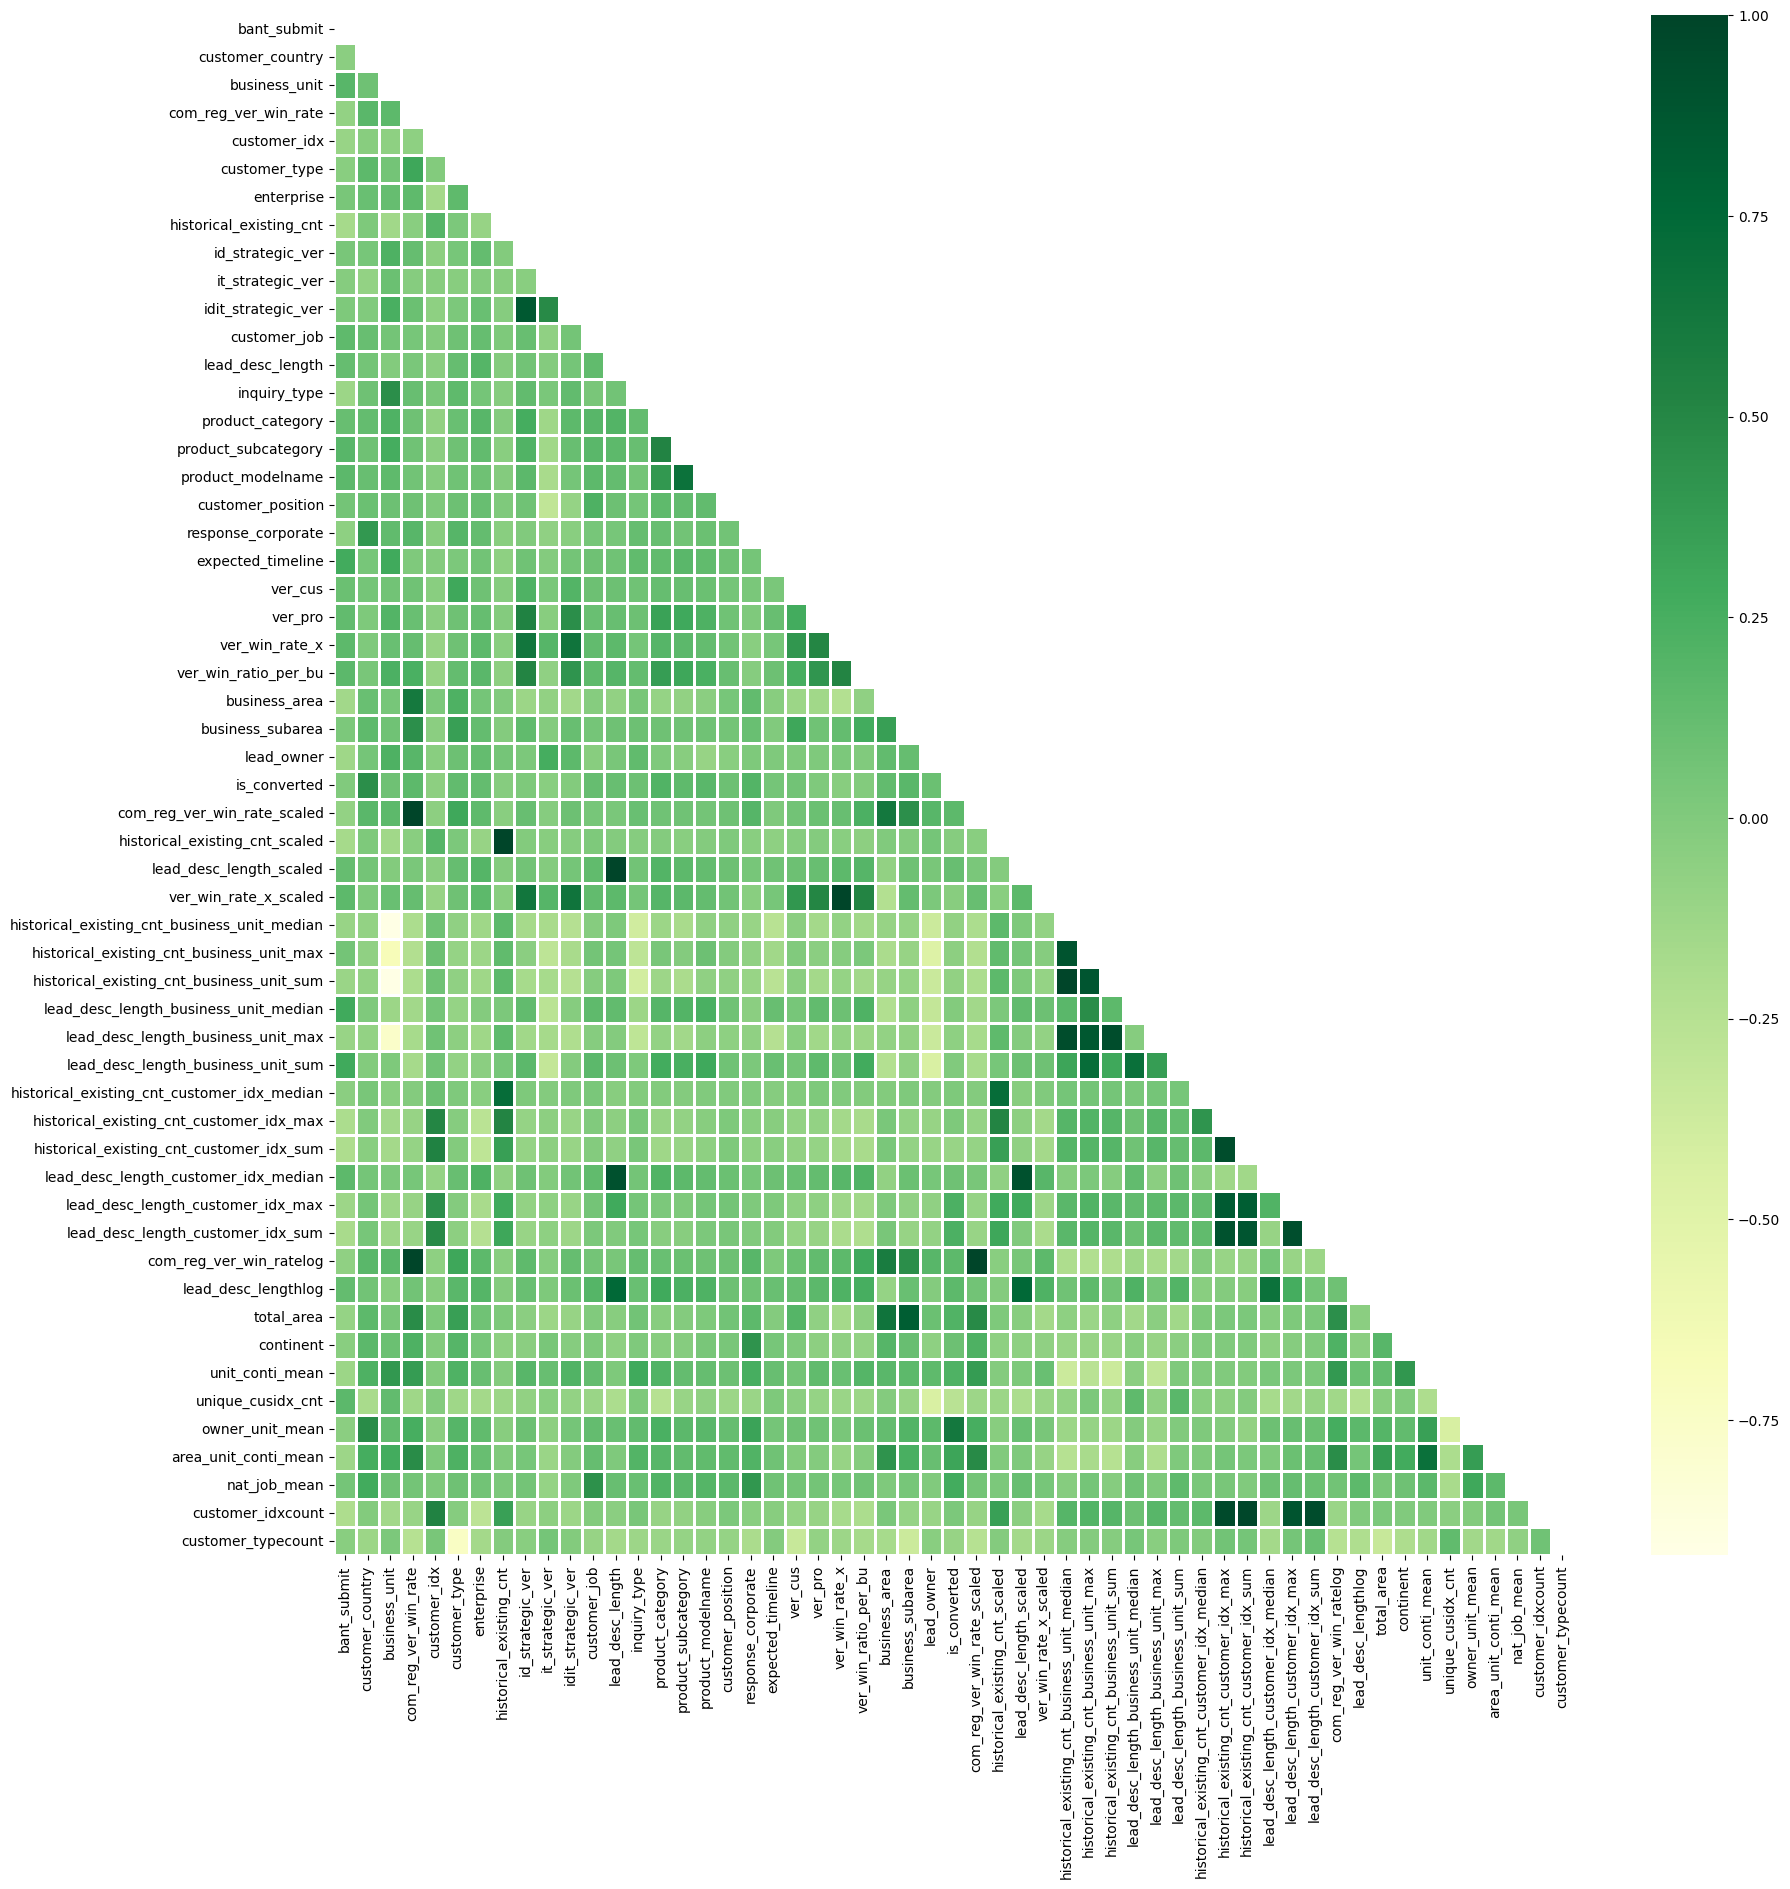

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

train = train.drop('customer_country.1', axis= 1)
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(data=corr, mask = mask, fmt = '.2f', linewidths=1., cmap='YlGn')

In [49]:
x

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,lead_desc_lengthlog,total_area,continent,unit_conti_mean,unique_cusidx_cnt,owner_unit_mean,area_unit_conti_mean,nat_job_mean,customer_idxcount,customer_typecount
0,1.00,0.206177,0.055826,0.066667,32160,0.113881,0.055952,0.0,0.0,0.0,...,4.143135,0.120010,0.080287,0.103521,5.468060,0.046620,0.097744,0.145161,2,6647
1,1.00,0.081789,0.055826,0.066667,23122,0.113881,0.055952,12.0,0.0,0.0,...,4.574711,0.132907,0.080287,0.103521,2.708050,0.750000,0.097744,0.333333,4,6647
2,1.00,0.423482,0.055826,0.088889,1755,0.113881,0.055952,144.0,0.0,0.0,...,4.043051,0.115009,0.080287,0.103521,2.772589,0.325000,0.097744,0.114993,3,6647
3,1.00,0.025082,0.055826,0.088889,4919,0.113881,0.055952,0.0,0.0,0.0,...,3.806662,0.128435,0.080287,0.103521,2.302585,0.379310,0.097744,0.108247,1,6647
4,1.00,0.104286,0.055826,0.088889,17126,0.074854,0.055952,0.0,0.0,0.0,...,4.584967,0.030493,0.080287,0.103521,3.258097,0.789474,0.097744,0.088825,1,2525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,0.027263,0.055826,0.000000,33747,0.177904,0.127159,0.0,0.0,0.0,...,5.303305,0.093627,0.040390,0.009235,4.382027,0.000000,0.000000,0.044944,2,3996
59295,0.75,0.081789,0.055826,0.040000,35420,0.074854,0.055952,0.0,0.0,0.0,...,4.262680,0.026022,0.068030,0.018777,5.361292,0.000000,0.027027,0.000000,1,2525
59296,0.75,0.081789,0.055826,0.040000,19249,0.074854,0.055952,0.0,0.0,0.0,...,3.555348,0.026022,0.068030,0.018777,5.641907,0.000000,0.027027,0.025714,1,2525
59297,1.00,0.081789,0.055826,0.040000,40327,0.065877,0.055952,0.0,0.0,0.0,...,5.934894,0.026022,0.068030,0.018777,4.043051,0.000000,0.027027,0.000000,1,43961


In [15]:
train['ver_pro'].value_counts()

ver_pro
0    56286
1     3013
Name: count, dtype: int64

In [16]:
train[train['ver_pro'] == 1]

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,lead_desc_lengthlog,total_area,continent,unit_conti_mean,unique_cusidx_cnt,owner_unit_mean,area_unit_conti_mean,nat_job_mean,customer_idxcount,customer_typecount
388,1.0,0.051706,0.102491,0.057534,20487,0.113881,0.055952,0.0,1.0,0.0,...,3.295837,0.185343,0.080287,0.082119,4.025352,0.516667,0.081272,0.088825,1,6647
389,1.0,0.081789,0.102491,0.057534,3452,0.113881,0.055952,0.0,1.0,0.0,...,2.397895,0.132907,0.080287,0.082119,3.465736,0.540541,0.081272,0.074275,1,6647
390,1.0,0.051706,0.102491,0.057534,23813,0.113881,0.055952,0.0,1.0,0.0,...,4.304065,0.202337,0.080287,0.082119,3.401197,1.000000,0.081272,0.134177,1,6647
391,1.0,0.189254,0.102491,0.057534,32208,0.113881,0.127159,0.0,1.0,0.0,...,5.164786,0.128435,0.080287,0.082119,4.948760,0.231481,0.081272,0.120501,1,6647
392,1.0,0.051706,0.102491,0.057534,29516,0.113881,0.055952,0.0,1.0,0.0,...,3.555348,0.144804,0.080287,0.082119,3.912023,0.476923,0.081272,0.110764,1,6647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58101,1.0,0.027263,0.102491,0.016949,36913,0.065877,0.055952,0.0,1.0,0.0,...,0.693147,0.021759,0.040390,0.078360,1.386294,0.000000,0.040724,0.000000,2,43961
58104,1.0,0.081789,0.102491,0.124122,20159,0.177904,0.127159,1.0,1.0,0.0,...,4.382027,0.650859,0.068030,0.179565,5.823046,0.288889,0.137845,0.053140,1,3996
58105,1.0,0.066915,0.102491,0.124122,35264,0.177904,0.055952,0.0,1.0,0.0,...,3.988984,0.650859,0.068030,0.179565,5.823046,0.288889,0.137845,0.065015,1,3996
58110,1.0,0.027775,0.102491,0.016949,29879,0.065877,0.127159,0.0,1.0,0.0,...,6.495266,0.021759,0.040390,0.078360,5.049856,0.000000,0.040724,0.025000,2,43961
